# Setup & Environment Verification — DreamScape AI

This notebook confirms that the environment is correctly configured, the **DreamBank Annotated** dataset loads from Hugging Face, and basic EDA works.

**It will:**
- Print library versions and runtime details
- Load a small sample of the dataset
- Run light cleaning and generate one plot
- Save a small processed JSON artifact for the project

Outputs saved to:
- `results/eda_plots.png`
- `data/processed/dreambank_clean.json`

In [1]:
# Core imports and version check
import sys, os, json, shutil, warnings, pathlib, platform
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib, seaborn
from datasets import load_dataset

# Optional torch presence
try:
    import torch
    TORCH_OK = True
except Exception:
    TORCH_OK = False

print("Environment check")
print("- OS:", platform.platform())
print("- Python:", sys.version.split()[0])
print("- pandas:", pd.__version__)
print("- matplotlib:", matplotlib.__version__)
print("- seaborn:", seaborn.__version__)
print("- datasets:", load_dataset.__module__.split('.')[0], "(🤗 datasets)")

if TORCH_OK:
    print("- torch:", torch.__version__)
    print("  CUDA available:", torch.cuda.is_available())
else:
    print("- torch: not installed (OK for EDA)")

Environment check
- OS: macOS-15.6.1-arm64-arm-64bit
- Python: 3.11.13
- pandas: 2.3.3
- matplotlib: 3.10.7
- seaborn: 0.13.2
- datasets: datasets (🤗 datasets)
- torch: 2.8.0
  CUDA available: False


In [2]:
# Ensure repo structure paths exist
BASE = Path(".").resolve()
DATA_RAW = BASE / "data" / "raw"
DATA_PROC = BASE / "data" / "processed"
RESULTS = BASE / "results"

for p in [DATA_RAW, DATA_PROC, RESULTS]:
    p.mkdir(parents=True, exist_ok=True)

# quick write permission check
testfile = BASE / "_perm_test"
with open(testfile, "w") as f:
    f.write("ok")
testfile.unlink()
print("Write permissions OK in", BASE)

Write permissions OK in /Users/saturnine/Dreamscape


## Load DreamBank Annotated (Hugging Face)

We load a **small subset** for speed and verification.

In [3]:
# Load small sample of the dataset for quick verification
ds = load_dataset("gustavecortal/DreamBank-annotated")
df = ds["train"].to_pandas()

print("Rows:", len(df), "| Columns:", list(df.columns))
df_sample = df.head(1000).copy()  # keep it light

# Show a few rows
display(df_sample[["name", "date", "report"]].head(5))

Rows: 27952 | Columns: ['id', 'name', 'number', 'time', 'date', 'gender', 'age', 'report', 'character', 'emotion']


,name,date,report
0,Alta: a detailed dreamer,1957,"The one at the Meads's house, where it's bigge..."
1,Alta: a detailed dreamer,8/11/67,I'm at a family reunion in a large fine house ...
2,Alta: a detailed dreamer,8/1/85,I watch a plane fly past and shortly realize i...
3,Alta: a detailed dreamer,1985?,Me pulling the green leaves and berries off so...
4,Alta: a detailed dreamer,1985?,I'm in a room that reminds me of (but definite...


## Basic Cleaning

- Drop null or very short texts  
- Normalize to a `text` column  
- Compute rough length for quick stats

In [4]:
try:
    from src.preprocess import length_filter
except Exception:
    def length_filter(df, col="report", min_chars=50):
        df = df.dropna(subset=[col]).copy()
        df["text"] = df[col].astype(str).str.strip()
        return df[df["text"].str.len() >= min_chars]

clean = length_filter(df_sample, col="report", min_chars=50)
clean["length"] = clean["text"].str.len()

print("After cleaning:", clean.shape)
display(clean[["name", "length", "text"]].head(3))

After cleaning: (978, 12)


,name,length,text
0,Alta: a detailed dreamer,867,"The one at the Meads's house, where it's bigge..."
1,Alta: a detailed dreamer,1306,I'm at a family reunion in a large fine house ...
2,Alta: a detailed dreamer,1693,I watch a plane fly past and shortly realize i...


## Early EDA — Length Distribution

We generate one simple histogram and save it to `results/eda_plots.png`.

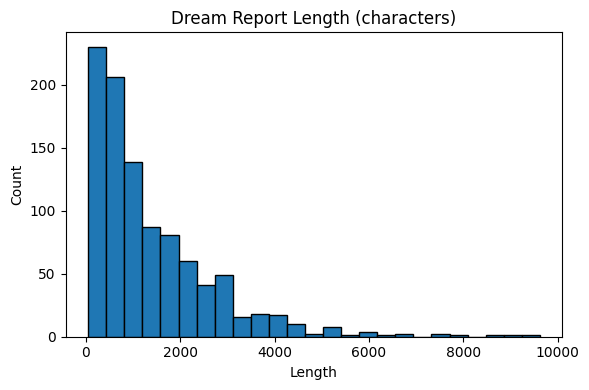

Saved plot -> /Users/saturnine/Dreamscape/results/eda_plots.png


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(clean["length"], bins=25, edgecolor="black")
plt.title("Dream Report Length (characters)")
plt.xlabel("Length"); plt.ylabel("Count")
plt.tight_layout()

out_plot = RESULTS / "eda_plots.png"
plt.savefig(out_plot, dpi=150, bbox_inches="tight")
plt.show()

print("Saved plot ->", out_plot)

## Save a Small Processed JSON

We store a small, cleaned subset for downstream notebooks.

In [6]:
out_json = DATA_PROC / "dreambank_clean.json"
cols_to_keep = ["id", "name", "date", "text"]  # small and useful

clean_small = clean[cols_to_keep].head(1000).copy()
clean_small.to_json(out_json, orient="records", lines=False, force_ascii=False)

print("Saved JSON ->", out_json, "| size:", out_json.stat().st_size, "bytes")

# quick load-back sanity check
loaded = pd.read_json(out_json, convert_dates=False)
print("Reloaded rows:", len(loaded))
display(loaded.head(3))

Saved JSON -> /Users/saturnine/Dreamscape/data/processed/dreambank_clean.json | size: 1427806 bytes
Reloaded rows: 978


,id,name,date,text
0,alta,Alta: a detailed dreamer,1957,"The one at the Meads's house, where it's bigge..."
1,alta,Alta: a detailed dreamer,8/11/67,I'm at a family reunion in a large fine house ...
2,alta,Alta: a detailed dreamer,8/1/85,I watch a plane fly past and shortly realize i...


### Quick Peek at Emotion Tags

The dataset includes a column `emotion` with tags like `AN`, `SD`, `JO`.  
We can quickly count non-null entries to demonstrate feature presence (no heavy modeling here).

In [7]:
if "emotion" in df.columns:
    emo_counts = df_sample["emotion"].dropna()
    print("Non-null emotion tag examples:", len(emo_counts))
    display(emo_counts.head(5))
else:
    print("No 'emotion' column found in this sample (ok).")

Non-null emotion tag examples: 571


4              CO D, AN 1MKA
6                 AN D, AN D
7                       AP D
11    CO 1FKA, AN 1FKA, CO D
13             AP D, HA 1MKA
Name: emotion, dtype: object

## ✅ Results

- Environment verified (versions printed above)  
- DreamBank Annotated successfully loaded from Hugging Face  
- Early EDA plot saved: `results/eda_plots.png`  
- Cleaned subset saved: `data/processed/dreambank_clean.json`

## ▶️ Next Notebooks
- `exploratory_data_analysis.ipynb`: deeper stats, cleaning & plots  
- `nlp_motif_extraction.ipynb`: transformer-based motifs/emotions  
- `visualization_summary.ipynb`: summary graphs & motif network

_This setup notebook is for the Deliverable 1 repository requirement._